# KEYBERT(SBERT) 를 이용한 Keyword 추출
- 참고 url : https://wikidocs.net/159467
- SBERT은 sentence_transformers 사용
- transfomers, sentence_transformers 다운로드 필요

In [1]:
import pandas as pd
import numpy as np
import itertools

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from konlpy.tag import Okt
from tqdm.notebook import tqdm

okt = Okt()

# 한국어를 포함하고 있는 다국어 SBERT load
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [3]:
df = pd.read_parquet('after_preprocessing.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361706 entries, 0 to 361705
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   source    361706 non-null  object
 1   content   361706 non-null  object
 2   postdate  361706 non-null  object
 3   platform  361706 non-null  object
dtypes: object(4)
memory usage: 11.0+ MB


# 1. 블로그 글 하나로 Test 해보기

In [3]:
doc = df['content'][0]
doc

'언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다 고간 제주 감귤 체험 알차게 즐기고 돌아온 여행 이었습니다 서귀포 남원읍 자리 휴애리 자연생활공원 볼수 있을 유명하답니다 지금 겨울 대표 동백꽃 넓은 부지 활짝 피어 있어 걷는 발길 마다 온통 핑크색 꽃길 걸어 볼수 있고 아기자기 다양한 포토 인생사진 남길수 있는 휴애리 동백 축제 기간 감귤 체험 할수 있는 시기 입니다 휴애리 자연생활공원 제주 서귀포시 남원읍 입장 시간 매일 하절기 입장 마감 입장 마감 휴애리 자연생활공원 주차장 제주특별자치도 서귀포시 남원읍 신례리 휴애리 입장료 성인 단체 단체 단체 유공 경로 우대 도민 자녀 이상 가구 할인 흑돼지 놀자 시간표 하루 흑돼지 공연 볼수 있으니 시간 맞춰 오시 하나 볼거리 있습니다 이건 따로 관람 없고 입장권 포함 입니다 반려견 동반 가능한 미만 소형견 입장 된다고 합니다 입장 하기 위해 선큐알 체크 온도 체크 꼼꼼하게 서서 마치 들어갑니다 시원하게 뿜어내는 분수 작은 연못 시작 해서 위쪽 올라가면 다른 세상 바로 펼쳐질 한라산 배경 동백꽃 함께 감귤 모자 여자 모습 너무도 사랑스럽네요 제주 휴애리 표지 모델 잡지 주인공 될수도 있으니 예쁘게 차려입거나 조금 밝은 입는게 모도 좋습니다 올레길 부터 걸어 볼까 입구 사람 많이 계셨고 연인 삼각대 세워놓고 커플사진 많이 찍는 모습 혼자 셀카 많이 찍는데이 동행 언니 계서 아주 맘껏 찍혀 보았습니다 공원 넓어서 내도 보고 사진 찍어 다니시는게 하나 안놓치고 볼수 있답니다 볼곳 굉장히 많기 때문 그냥 오면 아쉽고 비행기 타고 오는 한번 이맘때 기다려야 하니 실컷 돌아보시 핑크 리가 있었으면 더욱 아름다웠을 글씨 조형물 여기 단체사진 찍음 누가 봐도 제주 있구나 알수 있어 서자랑 사진 찍기 좋더라고요 여성 스럽고 공주 포토 있죠다 축제 즐기느라 조금 한가한 편이 꽃다발 들고 여유 있게 시간 보내 봅니다 걷다 보면 온실 카페 감귤 체험 흑돼지 공연장 먹이 주기 체험 곤충 테마 관등 있는 

In [6]:

tokenized_doc = okt.pos(doc)
stop_word = ['있는','있고','있으니','입니다.','이렇게','있을',]
print(tokenized_doc)
tokenized_list = [w for w,t in tokenized_doc if  t not in ['Verb'] or w in stop_word]


[('언니', 'Noun'), ('평소', 'Noun'), ('가보고', 'Verb'), ('싶어', 'Verb'), ('하던', 'Verb'), ('휴애리', 'Noun'), ('축제', 'Noun'), ('다녀왔어요', 'Verb'), ('지금', 'Noun'), ('한참', 'Noun'), ('만발', 'Noun'), ('해서', 'Verb'), ('꽃길', 'Noun'), ('걷다', 'Verb'), ('고간', 'Noun'), ('제주', 'Noun'), ('감귤', 'Noun'), ('체험', 'Noun'), ('알차게', 'Adjective'), ('즐기고', 'Verb'), ('돌아온', 'Verb'), ('여행', 'Noun'), ('이었습니다', 'Verb'), ('서귀포', 'Noun'), ('남원읍', 'Noun'), ('자리', 'Noun'), ('휴애리', 'Noun'), ('자연생활공원', 'Noun'), ('볼수', 'Verb'), ('있을', 'Adjective'), ('유명하답니다', 'Adjective'), ('지금', 'Noun'), ('겨울', 'Noun'), ('대표', 'Noun'), ('동백꽃', 'Noun'), ('넓은', 'Adjective'), ('부지', 'Noun'), ('활짝', 'Noun'), ('피어', 'Noun'), ('있어', 'Adjective'), ('걷는', 'Verb'), ('발길', 'Noun'), ('마다', 'Noun'), ('온통', 'Noun'), ('핑크색', 'Noun'), ('꽃길', 'Noun'), ('걸어', 'Verb'), ('볼수', 'Verb'), ('있고', 'Adjective'), ('아기자기', 'Noun'), ('다양한', 'Adjective'), ('포토', 'Noun'), ('인생사진', 'Noun'), ('남길수', 'Verb'), ('있는', 'Adjective'), ('휴애리', 'Noun'), ('동백', 'Noun'), ('축제', 'Noun'), 

In [7]:
tok_sentence = ' '.join(tokenized_list)
tok_sentence

'언니 평소 휴애리 축제 지금 한참 만발 꽃길 고간 제주 감귤 체험 알차게 여행 서귀포 남원읍 자리 휴애리 자연생활공원 있을 유명하답니다 지금 겨울 대표 동백꽃 넓은 부지 활짝 피어 있어 발길 마다 온통 핑크색 꽃길 있고 아기자기 다양한 포토 인생사진 있는 휴애리 동백 축제 기간 감귤 체험 있는 시기 입니다 휴애리 자연생활공원 제주 서귀포시 남원읍 입장 시간 매일 하절기 입장 마감 입장 마감 휴애리 자연생활공원 주차장 제주특별자치도 서귀포시 남원읍 신례리 휴애리 입장료 성인 단체 단체 단체 유공 경로 우대 도민 자녀 이상 가구 할인 흑돼지 시간표 하루 흑돼지 공연 있으니 시간 오시 하나 볼거리 있습니다 이건 따로 관람 없고 입장권 포함 입니다 반려견 동반 가능한 미만 소형견 입장 입장 위해 선큐알 체크 온도 체크 꼼꼼하게 서서 마치 시원하게 분수 작은 연못 시작 위쪽 다른 세상 바로 한라산 배경 동백꽃 함께 감귤 모자 여자 모습 너무도 사랑스럽네요 제주 휴애리 표지 모델 잡지 주인공 있으니 예쁘게 조금 모도 좋습니다 올레길 부터 입구 사람 많이 계셨고 연인 삼각대 커플사진 많이 모습 혼자 셀카 많이 동행 언니 계서 아주 맘껏 공원 넓어서 내도 보고 사진 하나 있답니다 볼곳 굉장히 많기 때문 그냥 아쉽고 비행기 타고 한번 이맘때 하니 실컷 핑크 리가 있었으면 더욱 아름다웠을 글씨 조형물 여기 단체사진 누가 제주 있구나 있어 서자랑 사진 찍기 좋더라고요 여성 스럽고 공주 포토 있죠다 축제 조금 한가한 편이 꽃다발 여유 있게 시간 온실 카페 감귤 체험 흑돼지 공연장 먹이 주기 체험 곤충 테마 관등 있는 메인 공간 온실 따뜻해서 좋고 다양한 식물 꽃들이 있어 잔잔한 볼거리 제공 있습니다 메리크리스마스 지금 휴애리 자연생활공원 트리 장식 있는데 이브 연인들 데이트 오기 딱인 입니다 온실 바로 카페 레드 그린 카페 영업 시간 입니다 우리 점심 바로 갈증 식곤증 있고 바로 커피 부터 마시기 아이스 아메리카노 아이스 야외 파라솔 아래 시원한 바람 주변 더욱 향기 맛있습니다 

# N_gram 단어 추출

- n_gram_range =(2,3) : bigram, trigram 추출
- CountVectiorizer : 단어들의 카운트로 문서를 벡터화

In [9]:
# N_gram 단어 추출


n_gram_range=(2,3)

#count = CountVectorizer(ngram_range=n_gram_range).fit([tok_sentence])
count = CountVectorizer().fit([tok_sentence]) 
candidates = count.get_feature_names()

print('candidates 개수:', len(candidates))
print(candidates[:100])


candidates 개수: 363
['가구', '가능한', '가도', '가득', '가면', '가위', '가장', '각자', '간다', '간단해요', '갈증', '감귤', '같아요', '같은', '거나', '걱정거리', '겨울', '경로', '계서', '계셨고', '계절', '고간', '고백', '곤충', '공간', '공연', '공연장', '공원', '공주', '과실', '과자', '관등', '관람', '굉장히', '구입', '귀엽고', '그냥', '그대', '그러고', '그럼', '그리움', '그린', '글씨', '기간', '기념품', '기분', '기선', '기억', '꼼꼼하게', '꽃길', '꽃다발', '꽃들이', '꽃말', '끼리', '나무', '나중', '낙화', '남아', '남원읍', '내도', '너무', '너무도', '넓어서', '넓은', '노란', '누가', '누구', '느낌', '다른', '다리', '다만', '다양한', '단체', '단체사진', '달달', '달라', '달콤합니다', '대박', '대표', '더욱', '덜하고', '데이트', '도민', '동반', '동백', '동백꽃', '동행', '뒷모습', '따뜻해서', '따로', '딱인', '때문', '라면', '레드', '리가', '리지', '마감', '마다', '마스크', '마시기']


# 모델 load 및 embedding
- 한국어를 포함하고 있는 다국어 SBERT load
- SBERT(sentence Bert)는 기본적으로 BERT의 문장 임베딩의 성능을 우수하게 개선시킨 모델
- 모델을 이용해 transformer embedding 진행
- 문서와 가장 유사한 키워드들을 cosain 유사도를 이용해 추출

In [10]:
# 한국어를 포함하고 있는 다국어 SBERT load
#model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [11]:
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

In [12]:
top_n = 5

distances = cosine_similarity(doc_embedding, candidate_embeddings)
# argsort = sort전 index값을 반환
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
keywords

['동백꽃', '꽃들이', '축제', '꽃길', '꽃다발']

# Max Sum Similarity

- 데이터 쌍 사이의 최대 합 거리는 데이터 쌍 간의 거리가 최대화되는 데이터 쌍
- 여기서의 의도는 후보 간의 유사성을 최소화하면서 문서와의 후보 유사성을 극대화 하는 것
- doc_embedding : 원본 자료 임베딩
- candidate_embeddings : vectorizing 후 임베딩
- words : 카운트가 높은 단어들 리스트
- top_n : 상위 몇개의 단어를 뽑을 것인지
- nr_candidates : 크기가 커질 수 록 더 다양한 키워드를 만듦

In [13]:
def max_sum_sim(doc_embedding, candidate_embeddings, words, top_n, nr_candidates):
    
    # 문서와 각 키워드들 간의 유사도
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    
    # 각 키워드들 간의 유사도
    distances_candidates = cosine_similarity(candidate_embeddings, candidate_embeddings)
    
    
    # 코사인 유사도에 기반하여 키워드들 중 상위 top_n개의 단어를 pick
    words_idx = list(distances.argsort()[0][-nr_candidates:]) 
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]
    
    # 각 키워드들 중에서 가장 덜 유사한 키워드들간의 조합을 계산
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]
    

In [14]:
max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n=5, nr_candidates=30)

['인생사진', '연인들', '자연생활공원', '공주', '메리크리스마스']

# Maximal Marginal Relevance
- 

In [57]:
def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):

    # 문서와 각 키워드들 간의 유사도가 적혀있는 리스트
    word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding)

    # 각 키워드들 간의 유사도
    word_similarity = cosine_similarity(candidate_embeddings)

    # 문서와 가장 높은 유사도를 가진 키워드의 인덱스를 추출.
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # keywords_idx = [2]
    keywords_idx = [np.argmax(word_doc_similarity)]

    # 가장 높은 유사도를 가진 키워드의 인덱스를 제외한 문서의 인덱스들
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # ==> candidates_idx = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10 ... 중략 ...]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    # 최고의 키워드는 이미 추출했으므로 top_n-1번만큼 아래를 반복.
    # ex) top_n = 5라면, 아래의 loop는 4번 반복됨.
    for _ in range(top_n - 1):
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # MMR을 계산
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # keywords & candidates를 업데이트
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [28]:
mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)

['꽃다발', '메리크리스마스', '연인들', '축제', '자연생활공원', '비행기', '그리움', '공주', '휴애리', '아름다웠을']

# 2. 한 관광지의 전체 글 키워드 추출

In [26]:
source = df['source'].unique()

doc_list = df[df['source']==source[0]]['content']
doc_list

0      언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다...
1      안녕하세요 아델라 입니다 이번 포스팅 휴애리 자연생활공원 사진 많은 이었어요 저희 ...
2      제주도 휴애리 자연생활공원 제주 매화축제 구경 제주 서귀포시 남원읍 매일 연중 입장...
3      안녕하세요 량애 절반 지나가고 있네요 아직도 머물러 있어요 제주도 여행 다녀온지 얼...
4      서귀포 가볼만 휴애리 자연생활공원 동백 포토 진짜 제주도 가서 이렇게 동백 미친듯이...
                             ...                        
693    초여름 사실 신록 어울림 느낄 있는 시기 여전히 미세먼지 걱정 앞서긴 공기 맑은 바...
694    여행 비수기 하죠 놓치지 말아야 축제 열린다는 마지막 겨울 만끽 있는 얼음 낚시 벌...
695    아이 데리 나들이 하기 좋은 가을 맞아 선선 바람 타고 전국 축제 소식 들리네요 예...
696    언제 가도 누구 함께 해도 즐거운 제주 여행 제주도 여행 가시는 들이라면 어느 지역...
697    새해 골프 여행 인기 계속 됩니다 해외 골프여행 갈만 정말 많지만 국내 혹은 당일치...
Name: content, Length: 698, dtype: object

In [50]:
for i,doc in enumerate(doc_list):
    

    tokenized_doc = okt.pos(doc)
    stop_word = ['있는','있고','있으니','입니다.','이렇게','있을',source[0]]
    #print(tokenized_doc)
    tokenized_list = [w for w,t in tokenized_doc if  t not in ['Verb'] or w in stop_word]

    tok_sentence = ' '.join(tokenized_list)

    n_gram_range=(2,3)

    #count = CountVectorizer(ngram_range=n_gram_range).fit([tok_sentence])
    count = CountVectorizer().fit([tok_sentence]) 
    candidates = count.get_feature_names()



    doc_embedding = model.encode([doc])
    candidate_embeddings = model.encode(candidates)


    # distances = cosine_similarity(doc_embedding, candidate_embeddings)
    # # argsort = sort전 index값을 반환
    # keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
    # keywords

    df.loc[i,'keyword']= ', '.join(mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5))

In [69]:
#df1.to_parquet("add_keyword.parquet",compression='gzip')

In [23]:
keyword_df = pd.read_parquet('add_keyword.parquet')

In [25]:
#count = CountVectorizer().fit([key]) 
#candidates = count.get_feature_names()
from collections import Counter

key = ' '.join(keyword_df['keyword'])

result = Counter(key.split(','))
#result.most_commonst_common(10)
result.most_common(20)

[(' 자연생활공원', 287),
 (' 휴애리자연생활공원', 181),
 (' 휴애리', 175),
 (' 곤충', 109),
 (' 제주특별자치도', 97),
 (' 매화축제', 91),
 (' 축제', 85),
 (' 겨울', 79),
 (' 공간', 73),
 (' 흑돼지', 65),
 (' 인터넷', 55),
 (' 판매', 55),
 (' 계획', 51),
 (' 꽃들이', 45),
 (' 사진찍기', 41),
 (' 감귤', 41),
 (' 당근', 39),
 (' 여행', 37),
 (' 여름', 37),
 (' 제주도여행', 35)]

# 3. TF-IDF Vectorizing으로 전체 글 키워드 추출

In [163]:
source = df['source'].unique()
print(source)
tfidf_df = df[df['source']==source[1]]

tfidf_doc = list(tfidf_df['content'])

tfidf_tok = []
for i,d in enumerate(tfidf_doc):
    tokenized_doc = okt.pos(d)
    stop_word = ['있는','있고','있으니','입니다.','이렇게','있을', tour, tour.replace(' ','')]
    tfidf_tok.append(' '.join([w for w,t in tokenized_doc if  t not in ['Verb'] or w not in stop_word]))
    print(len(tfidf_doc),'/',i+1)

vectorizer = TfidfVectorizer(analyzer = 'word',min_df=2)

vectorizer.fit(tok_list)

tfidf_candidates = vectorizer.get_feature_names()

tfidf_doc_embedding = model.encode(tfidf_doc)
tfidf_candidate_embeddings = model.encode(tfidf_candidates)



633 / 1
633 / 2
633 / 3
633 / 4
633 / 5
633 / 6
633 / 7
633 / 8
633 / 9
633 / 10
633 / 11
633 / 12
633 / 13
633 / 14
633 / 15
633 / 16
633 / 17
633 / 18
633 / 19
633 / 20
633 / 21
633 / 22
633 / 23
633 / 24
633 / 25
633 / 26
633 / 27
633 / 28
633 / 29
633 / 30
633 / 31
633 / 32
633 / 33
633 / 34
633 / 35
633 / 36
633 / 37
633 / 38
633 / 39
633 / 40
633 / 41
633 / 42
633 / 43
633 / 44
633 / 45
633 / 46
633 / 47
633 / 48
633 / 49
633 / 50
633 / 51
633 / 52
633 / 53
633 / 54
633 / 55
633 / 56
633 / 57
633 / 58
633 / 59
633 / 60
633 / 61
633 / 62
633 / 63
633 / 64
633 / 65
633 / 66
633 / 67
633 / 68
633 / 69
633 / 70
633 / 71
633 / 72
633 / 73
633 / 74
633 / 75
633 / 76
633 / 77
633 / 78
633 / 79
633 / 80
633 / 81
633 / 82
633 / 83
633 / 84
633 / 85
633 / 86
633 / 87
633 / 88
633 / 89
633 / 90
633 / 91
633 / 92
633 / 93
633 / 94
633 / 95
633 / 96
633 / 97
633 / 98
633 / 99
633 / 100
633 / 101
633 / 102
633 / 103
633 / 104
633 / 105
633 / 106
633 / 107
633 / 108
633 / 109
633 / 110
633 / 11

In [170]:
top_n = 20

distances = cosine_similarity(tfidf_doc_embedding, tfidf_candidate_embeddings)
# argsort = sort전 index값을 반환
keywords = [tfidf_candidates[index] for index in distances.argsort()[0][-top_n:]] 
keywords

['싶었는데',
 '들어서면',
 '했답니다',
 '보고싶다면',
 '했는데도',
 '걸어가니까',
 '만나고',
 '해야죠',
 '만나게',
 '제주도여행지',
 '좋아해서',
 '제주수국축제',
 '제주도수국축제',
 '찾아보니',
 '들어서자마자',
 '힘들었어요',
 '해드릴게요',
 '큰엉해안경승지',
 '만들어놓았더라고요',
 '꾸며놓았더라고요']

In [171]:
tfidf_candidates[distances.argsort()[0][0]]

'장애인'

# 4. 계절별 키워드 추출 

In [28]:
keyword_df['postdate']= pd.to_datetime(keyword_df['postdate'],format='%Y/%m/%d')
keyword_df['season'] = keyword_df['postdate'].dt.month
keyword_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 0 to 697
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   source    698 non-null    object        
 1   content   698 non-null    object        
 2   postdate  698 non-null    datetime64[ns]
 3   platform  698 non-null    object        
 4   keyword   698 non-null    object        
 5   season    698 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 38.2+ KB


In [29]:
#df['quarter']=df['postdate'].dt.quarter
def season(month):
    result = 1 
    
    if month in [3, 4, 5]:
        result = 1
    elif month in [6, 7, 8]:
        result = 2
    elif month in [9, 10, 11]:
        result = 3
    else:
        result = 4
        
    return result
    
keyword_df['season']=keyword_df['season'].map(season)

In [32]:
season = list(keyword_df.groupby('season')['keyword'].sum())
len(season)

4

In [33]:
season[0]

'제주특별자치도, 자판기, 벚꽃, 카펫, 사진찍기, 겨울, 놀이, 흑돼지, 터널, 청소년네이버, 웨딩촬영, 욕심, 자판기, 자연생활공원, 매화축제, 곤충, 주차장, 계획, 추워서제주특별자치도, 텃밭, 계획, 판매, 추워서, 곤충, 당근, 남녀, 흑돼지, 매화축제여름, 고객, 정원, 휴애리자연생활공원, 안녕하세요, 축제, 출퇴근길, 어린이날, 인터넷, 국정원꽃봉오리, 강풍, 대다수, 영상, 휴애리매화축제, 자연, 화가, 폭포수, 축제, 현장제주특별자치도, 벚꽃, 어린이, 동남아, 감기예방, 토끼, 놀이, 터널, 전통, 염소한국, 두툼, 매화축제, 쏭쏭, 정글, 제주공항, 구실잣밤나무, 제주특별자치도, 고기, 거리네이버, 자연생활공원, 곤충, 매화축제, 휴애리, 귤나무, 공간, 블로거, 색깔, 제주특별자치도제주3월동백꽃, 휴애리자연생활공원, 네이버, 정원, 후회, 미남, 제주비올때, 귤나무, 여행기, 자녀매화축제, 휴애리자연생활공원매화, 자연, 풍부한, 꽃들이, 화산, 여름, 사진찍기, 제주휴애리매화축제, 면역력제주도, 관람객, 매화축제, 산림, 모바일, 산토끼, 인터넷, 공간, 비싼, 감귤네이버, 휴애리자연생활공원, 계획, 공간, 제주여행, 유럽, 흑돼지, 마스크, 종이, 금가면제주도관광지, 꽃밭, 사진찍기, 재미있는, 지도, 신혼부부, 관광객, 휴애리자연생활공원, 자연생활공원, 마스크네이버, 휴애리자연생활공원, 아쉬웠답니다, 주차장, 반려견, 동백꽃, 영어, 입구, 제주보름살이, 제주여행제주, 매화나무, 자연생활공원, 고생, 산책, 공간, 흙돼지, 휴애리, 공연장, 연인네이버, 자연생활공원, 매화축제, 휴애리, 공간, 색깔, 당근, 제주특별자치도, 판매, 흑돼지제주특별자치도, 문제, 재배, 가이드, 색깔, 몰리, 폭탄, 공간, 바람, 커피타임휴애리, 매화축제, 천국, 겨울, 여름, 가족, 자연생활공원, 시간, 축제, 제주특별자치도제주특별자치도, 식당, 케이크, 비행기, 동문시장, 동쪽, 아침식사, 온실, 당근, 패션주의보, 벚꽃, 부자, 농사일, 초여름, 여행

In [34]:
for i,q in enumerate(season):
    result = Counter(q.split(','))
    print(i,result.most_common(10))
    print()

0 [(' 자연생활공원', 63), (' 휴애리자연생활공원', 45), (' 휴애리', 33), (' 매화축제', 27), (' 공간', 23), (' 곤충', 21), (' 벚꽃', 20), (' 축제', 20), (' 제주특별자치도', 18), (' 겨울', 16)]

1 [(' 자연생활공원', 78), (' 휴애리자연생활공원', 41), (' 휴애리', 37), (' 곤충', 26), (' 제주특별자치도', 24), (' 축제', 21), (' 매화축제', 20), (' 흑돼지', 16), (' 공간', 16), (' 여행', 15)]

2 [(' 자연생활공원', 51), (' 휴애리', 37), (' 휴애리자연생활공원', 35), (' 곤충', 35), (' 제주특별자치도', 20), (' 흑돼지', 14), (' 공간', 14), (' 겨울', 14), (' 축제', 13), (' 판매', 13)]

3 [(' 자연생활공원', 95), (' 휴애리', 68), (' 휴애리자연생활공원', 60), (' 겨울', 39), (' 제주특별자치도', 35), (' 매화축제', 32), (' 축제', 31), (' 곤충', 27), (' 흑돼지', 23), (' 인터넷', 21)]



In [35]:
season_size = keyword_df.groupby('season').size()
season_size

season
1    161
2    154
3    136
4    247
dtype: int64

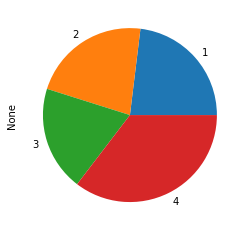

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = season_size.plot(kind='pie')
plt.show()

# 5. 계절별 데이터 TF-IDF를 이용해 벡터라이징

In [37]:
#df = pd.read_parquet('after_preprocessing.parquet')
df['postdate']= pd.to_datetime(df['postdate'],format='%Y/%m/%d')
df['season'] = df['postdate'].dt.month
df.info()

source = df['source'].unique()
df
# doc_list = df[df['source']==source[0]]['content']
# doc_list

,source,content,postdate,platform,season
0,휴애리 자연생활공원,언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다...,2021-12-17,naver,4
1,휴애리 자연생활공원,안녕하세요 아델라 입니다 이번 포스팅 휴애리 자연생활공원 사진 많은 이었어요 저희 ...,2022-02-27,naver,4
2,휴애리 자연생활공원,제주도 휴애리 자연생활공원 제주 매화축제 구경 제주 서귀포시 남원읍 매일 연중 입장...,2022-03-06,naver,1
3,휴애리 자연생활공원,안녕하세요 량애 절반 지나가고 있네요 아직도 머물러 있어요 제주도 여행 다녀온지 얼...,2022-01-27,naver,4
4,휴애리 자연생활공원,서귀포 가볼만 휴애리 자연생활공원 동백 포토 진짜 제주도 가서 이렇게 동백 미친듯이...,2022-01-04,naver,4
...,...,...,...,...,...
361701,1100고지(휴게소),크레마 알맞게 덮힌 진한 커피 두툼 내리고 감싸 온기 먼저 마시는 살짝 서리 펑펑 ...,2020-12-20,brunch,4
361702,(주)제주해양레저 투명카약,제주해양레저 즐기며 특별한 경험 되는 제주 오션 파크 제주 해양레저 즐기러 오는 사...,2019-06-18,naver,2
361703,(주)제주해양레저 투명카약,제주 가볼만 제주도 렌트카 지도 보고 버스 타고 뚜벅 여행 권역별 지선 버스 노선 ...,2021-05-08,naver,1
361704,(주)제주해양레저 투명카약,우리나라 바다 모두 특색 있고 아름다워 사계절 내내 예쁜 비경 자랑 하는데요 제주도...,2018-12-24,naver,4


In [152]:
tour = source[0]
tour_df = df[df['source']==tour]

season_list = list(tour_df[tour_df['season']==1]['content'])
season_list

# vectorizer = TfidfVectorizer(analyzer = 'char',min_df=2)

# vectorizer.fit(tok_list)
# #sorted(vectorizer.vocabulary_.items())
# sorted(vectorizer.vocabulary_.items())

[(' ', 0),
 ('!', 1),
 ('#', 2),
 (')', 3),
 ('.', 4),
 ('0', 5),
 ('1', 6),
 ('2', 7),
 ('3', 8),
 ('4', 9),
 ('5', 10),
 ('^', 11),
 ('_', 12),
 ('e', 13),
 ('g', 14),
 ('j', 15),
 ('l', 16),
 ('m', 17),
 ('o', 18),
 ('r', 19),
 ('t', 20),
 ('u', 21),
 ('~', 22),
 ('가', 23),
 ('각', 24),
 ('간', 25),
 ('갇', 26),
 ('갈', 27),
 ('감', 28),
 ('갑', 29),
 ('값', 30),
 ('갔', 31),
 ('강', 32),
 ('갖', 33),
 ('같', 34),
 ('개', 35),
 ('객', 36),
 ('갤', 37),
 ('갯', 38),
 ('거', 39),
 ('걱', 40),
 ('건', 41),
 ('걷', 42),
 ('걸', 43),
 ('검', 44),
 ('겁', 45),
 ('것', 46),
 ('겉', 47),
 ('게', 48),
 ('겠', 49),
 ('겨', 50),
 ('격', 51),
 ('견', 52),
 ('결', 53),
 ('겸', 54),
 ('겹', 55),
 ('겼', 56),
 ('경', 57),
 ('곁', 58),
 ('계', 59),
 ('고', 60),
 ('곡', 61),
 ('곤', 62),
 ('곧', 63),
 ('골', 64),
 ('곱', 65),
 ('곳', 66),
 ('공', 67),
 ('과', 68),
 ('관', 69),
 ('광', 70),
 ('괜', 71),
 ('괴', 72),
 ('굉', 73),
 ('교', 74),
 ('구', 75),
 ('국', 76),
 ('군', 77),
 ('굳', 78),
 ('굴', 79),
 ('굽', 80),
 ('굿', 81),
 ('궁', 82),
 ('권', 83),
 (

In [143]:
tok_list=[]
for i,d in enumerate(season_list):
    tokenized_doc = okt.pos(d)
    stop_word = ['있는','있고','있으니','입니다.','이렇게','있을', tour, tour.replace(' ','')]
    tok_list.append(' '.join([w for w,t in tokenized_doc if  t not in ['Verb'] or w not in stop_word]))
    print(len(season_list),'/',i)


161 / 0
161 / 1
161 / 2
161 / 3
161 / 4
161 / 5
161 / 6
161 / 7
161 / 8
161 / 9
161 / 10
161 / 11
161 / 12
161 / 13
161 / 14
161 / 15
161 / 16
161 / 17
161 / 18
161 / 19
161 / 20
161 / 21
161 / 22
161 / 23
161 / 24
161 / 25
161 / 26
161 / 27
161 / 28
161 / 29
161 / 30
161 / 31
161 / 32
161 / 33
161 / 34
161 / 35
161 / 36
161 / 37
161 / 38
161 / 39
161 / 40
161 / 41
161 / 42
161 / 43
161 / 44
161 / 45
161 / 46
161 / 47
161 / 48
161 / 49
161 / 50
161 / 51
161 / 52
161 / 53
161 / 54
161 / 55
161 / 56
161 / 57
161 / 58
161 / 59
161 / 60
161 / 61
161 / 62
161 / 63
161 / 64
161 / 65
161 / 66
161 / 67
161 / 68
161 / 69
161 / 70
161 / 71
161 / 72
161 / 73
161 / 74
161 / 75
161 / 76
161 / 77
161 / 78
161 / 79
161 / 80
161 / 81
161 / 82
161 / 83
161 / 84
161 / 85
161 / 86
161 / 87
161 / 88
161 / 89
161 / 90
161 / 91
161 / 92
161 / 93
161 / 94
161 / 95
161 / 96
161 / 97
161 / 98
161 / 99
161 / 100
161 / 101
161 / 102
161 / 103
161 / 104
161 / 105
161 / 106
161 / 107
161 / 108
161 / 109
161 / 110


False

In [157]:
vectorizer = TfidfVectorizer(analyzer = 'word',min_df=2)

vectorizer.fit(tok_list)
#sorted(vectorizer.vocabulary_.items())
sorted(vectorizer.vocabulary_.items())

[('jeju', 0),
 ('가게', 1),
 ('가격', 2),
 ('가고', 3),
 ('가고싶어서', 4),
 ('가고싶어요', 5),
 ('가구', 6),
 ('가기', 7),
 ('가기전에', 8),
 ('가긴', 9),
 ('가까운', 10),
 ('가까워', 11),
 ('가까워서', 12),
 ('가까이', 13),
 ('가꿔진', 14),
 ('가끔', 15),
 ('가나', 16),
 ('가는', 17),
 ('가는길', 18),
 ('가능', 19),
 ('가능하고', 20),
 ('가능하기', 21),
 ('가능하니', 22),
 ('가능하다', 23),
 ('가능하다고', 24),
 ('가능하다는', 25),
 ('가능하답니다', 26),
 ('가능한', 27),
 ('가능한데', 28),
 ('가능한데요', 29),
 ('가능할', 30),
 ('가능함', 31),
 ('가능합니다', 32),
 ('가능해서', 33),
 ('가능해요', 34),
 ('가능했던', 35),
 ('가니', 36),
 ('가다', 37),
 ('가더라도', 38),
 ('가던', 39),
 ('가도', 40),
 ('가득', 41),
 ('가득가득', 42),
 ('가득하게', 43),
 ('가득하고', 44),
 ('가득하다', 45),
 ('가득하답니다', 46),
 ('가득한', 47),
 ('가득한데', 48),
 ('가득할', 49),
 ('가득합니다', 50),
 ('가득해', 51),
 ('가득해서', 52),
 ('가득해요', 53),
 ('가득했다', 54),
 ('가득했던', 55),
 ('가든', 56),
 ('가디건', 57),
 ('가랜드', 58),
 ('가량', 59),
 ('가렌', 60),
 ('가려고', 61),
 ('가로', 62),
 ('가루', 63),
 ('가를', 64),
 ('가만', 65),
 ('가만히', 66),
 ('가면', 67),
 ('가방', 68),
 ('가벼운', 69),
 ('가볍게', 70),

In [158]:
candidates = vectorizer.get_feature_names()



doc_embedding = model.encode(season_list)
candidate_embeddings = model.encode(candidates)


# distances = cosine_similarity(doc_embedding, candidate_embeddings)
# # argsort = sort전 index값을 반환
# keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
# keywords

#mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)

In [154]:
len(doc_embedding)

161

In [155]:
word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding)
#cosine_similarity(candidate_embeddings)[0]
word_doc_similarity

len(word_doc_similarity)
maxk = [np.argmax(word_doc_similarity)]

temp_doc = word_doc_similarity.ravel()
candi_idx = [i for i in range(len(candidates)) if i != maxk[0]]
candi_idx
temp_doc[candi_idx,:]
#temp_doc[candi_idx, :]
#temp[maxk]
#max(word_doc_similarity[0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [159]:
top_n = 40

distances = cosine_similarity(doc_embedding, candidate_embeddings)
# argsort = sort전 index값을 반환
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
keywords

['제주',
 '제주다',
 '남친',
 'jeju',
 '제주도수국축제',
 '제주도가볼만한곳',
 '영산홍',
 '제주흑돼지',
 '제주시',
 '한림공원',
 '김밥',
 '아이와제주여행',
 '국내',
 '제주한달살이',
 '제주수국축제',
 '강원도',
 '제주도수국',
 '김치',
 '연출',
 '서울',
 '제주도',
 '성산읍',
 '제주수국',
 '경기도',
 '드라마',
 '제주도관광지',
 '제주여행',
 '인스타',
 '부산',
 '제주공항',
 '제주휴애리',
 '제주특별자치도',
 '제주도여행',
 '제주도여행지',
 '한국',
 '대한민국',
 '한반도',
 '제주도휴애리',
 '네이버',
 '김포공항']

In [120]:
def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):

    # 문서와 각 키워드들 간의 유사도가 적혀있는 리스트
    word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding).flatten()

    # 각 키워드들 간의 유사도
    word_similarity = cosine_similarity(candidate_embeddings)

    # 문서와 가장 높은 유사도를 가진 키워드의 인덱스를 추출.
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # keywords_idx = [2]
    keywords_idx = [np.argmax(word_doc_similarity)]

    # 가장 높은 유사도를 가진 키워드의 인덱스를 제외한 문서의 인덱스들
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # ==> candidates_idx = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10 ... 중략 ...]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    # 최고의 키워드는 이미 추출했으므로 top_n-1번만큼 아래를 반복.
    # ex) top_n = 5라면, 아래의 loop는 4번 반복됨.
    for _ in range(top_n - 1):
        #candidate_similarities = word_doc_similarity[candidates_idx, :].reshape(-1,1)
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # MMR을 계산
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # keywords & candidates를 업데이트
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [121]:
mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

True